In [23]:
%reset -f

In [2]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage import io  # for reading TIFF images
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, EarlyStopping
import time

In [3]:
# Set the desired number of patches
desired_num_patches = 7566

# Your data directories
dsm_images_dir = 'DSM_Clip_Patches'
solar_map_dir = 'Solar_Clip_Patches'

# Get the list of file names in the directories without sorting
dsm_files = os.listdir(dsm_images_dir)
solar_map_files = os.listdir(solar_map_dir)



In [4]:
# Initialize empty lists to store data
x_train_list = []
solar_values_list = []


# Loop through each patch with tqdm for progress bars
for i in tqdm(range(min(desired_num_patches, len(dsm_files))), desc='Loading Patches'):
    # Get file names for the current index
    dsm_file = dsm_files[i]
    solar_map_file = solar_map_files[i]
    
    # Load images
    dsm_image = io.imread(os.path.join(dsm_images_dir, dsm_file))
    solar_map = io.imread(os.path.join(solar_map_dir, solar_map_file))

    # Normalize the data using min-max scaling for DSM
    if np.min(dsm_image) != np.max(dsm_image):
        dsm_image_normalized = (dsm_image - np.min(dsm_image)) / (np.max(dsm_image) - np.min(dsm_image))
    else:
        dsm_image_normalized = dsm_image

    # Ensure the shape matches the specified format
    dsm_image_normalized = np.expand_dims(dsm_image_normalized, axis=-1)

    # Expand dimensions for solar map to match the channel dimension
    solar_map = np.expand_dims(solar_map, axis=-1)

    x_train_list.append(dsm_image_normalized)
    solar_values_list.append(solar_map)

    # Break the loop when desired_num_patches is reached
    if len(x_train_list) >= desired_num_patches:
        break

# Combine all patches into single arrays
x_data_dsm = np.stack(x_train_list)
solar_values = np.stack(solar_values_list)

# Ensure the solar values have the correct shape
solar_values = np.squeeze(solar_values, axis=(3,))

# Normalize solar values using min-max scaling
min_solar = np.min(solar_values)
max_solar = np.max(solar_values)
solar_scaled = (solar_values - min_solar) / (max_solar - min_solar)

# Reshape scaled solar values for compatibility with the model
solar_normalized = np.expand_dims(solar_scaled, axis=-1)

# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data_dsm, solar_normalized, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

# Print the shapes of the datasets
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

input_shape = x_train.shape[1:]


Loading Patches: 100%|█████████▉| 7565/7566 [00:41<00:00, 181.36it/s]


x_train: (4841, 128, 128, 1)
y_train: (4841, 128, 128, 1)
x_val shape: (1211, 128, 128, 1)
y_val shape: (1211, 128, 128, 1)
x_test shape: (1514, 128, 128, 1)
y_test shape: (1514, 128, 128, 1)


In [5]:
print(np.max(solar_values))
print(np.min(solar_values))
print(np.max(dsm_image))
print(np.min(dsm_image))
print(np.max(dsm_image_normalized))
print(np.min(dsm_image_normalized))

1045434.44
0.0
14.243
-1.211
1.0
0.0


In [22]:
# import numpy as np
# from skimage import io
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# # Initialize empty lists to store data
# x_data_list = []
# y_data_list = []

# # Load all solar map images without normalization
# solar_maps = [io.imread(os.path.join(solar_map_dir, file)) for file in solar_map_files]

# # Concatenate all solar maps along the batch axis
# solar_maps_concatenated = np.concatenate(solar_maps, axis=0)

# # Compute the minimum and maximum values of the concatenated solar maps
# solar_min = np.min(solar_maps_concatenated)
# solar_max = np.max(solar_maps_concatenated)

# # Print the minimum and maximum values
# print("Min Solar Map Value:", solar_min)
# print("Max Solar Map Value:", solar_max)

# # Loop through each patch with tqdm for progress bars
# for i in tqdm(range(min(desired_num_patches, len(dsm_files))), desc='Loading Patches'):
#     # Get file names for the current index
#     dsm_file = dsm_files[i]
#     solar_map_file = solar_map_files[i]
    
#     # Load images
#     dsm_image = io.imread(os.path.join(dsm_images_dir, dsm_file))
#     solar_map = io.imread(os.path.join(solar_map_dir, solar_map_file))

#     # Normalize the data using min-max scaling for DSM
#     if np.min(dsm_image) != np.max(dsm_image):
#         dsm_image_normalized = (dsm_image - np.min(dsm_image)) / (np.max(dsm_image) - np.min(dsm_image))
#     else:
#         dsm_image_normalized = dsm_image

#     # Normalize the data using min-max scaling for Solar Map
#     if solar_min != solar_max:
#         solar_map_normalized = (solar_map - solar_min) / (solar_max - solar_min)
#     else:
#         solar_map_normalized = solar_map

#     # Ensure the shapes match the specified format
#     dsm_image_normalized = np.expand_dims(dsm_image_normalized, axis=-1)
#     solar_map_normalized = np.expand_dims(solar_map_normalized, axis=-1)

#     x_data_list.append(dsm_image_normalized)
#     y_data_list.append(solar_map_normalized)

#     # Break the loop when desired_num_patches is reached
#     if len(x_data_list) >= desired_num_patches:
#         break

# # Combine all patches into a single array
# x_data = np.stack(x_data_list)
# y_data = np.stack(y_data_list)

# # Split the data into training, validation, and test sets
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# # Print the shapes of the datasets
# print('x_train:', x_train.shape)
# print('y_train:', y_train.shape)
# print('x_val shape:', x_val.shape)
# print('y_val shape:', y_val.shape)
# print('x_test shape:', x_test.shape)
# print('y_test shape:', y_test.shape)

# input_shape = x_data.shape[1:]


Min Solar Map Value: 0.0
Max Solar Map Value: 1049290.1


Loading Patches: 100%|█████████▉| 4999/5000 [00:04<00:00, 1185.41it/s]


x_train: (3200, 128, 128, 1)
y_train: (3200, 128, 128, 1)
x_val shape: (800, 128, 128, 1)
y_val shape: (800, 128, 128, 1)
x_test shape: (1000, 128, 128, 1)
y_test shape: (1000, 128, 128, 1)


In [6]:


# Define the U-Net model
inputs = Input(input_shape)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 

In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-3
    print('Learning rate: ', lr)
    return lr

In [8]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [15]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                           

In [16]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('Solar_UNET.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=300, monitor='val_mae'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]
start_time = time.time()
results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=300 ,
callbacks= callbacks)
end_time = time.time()
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60

print("Training completed in {:.2f} seconds ({:.2f} minutes)".format(training_time_seconds, training_time_minutes))

Epoch 1/300
152/152 [==============================] - ETA: 0s - loss: 0.0532 - mae: 0.1748
Epoch 1: val_loss improved from inf to 0.06725, saving model to Solar_UNET.h5
152/152 [==============================] - 7s 41ms/step - loss: 0.0532 - mae: 0.1748 - val_loss: 0.0673 - val_mae: 0.1943
Epoch 2/300
150/152 [============================>.] - ETA: 0s - loss: 0.0514 - mae: 0.1693
Epoch 2: val_loss improved from 0.06725 to 0.06392, saving model to Solar_UNET.h5
152/152 [==============================] - 5s 34ms/step - loss: 0.0513 - mae: 0.1692 - val_loss: 0.0639 - val_mae: 0.1866
Epoch 3/300
151/152 [============================>.] - ETA: 0s - loss: 0.0497 - mae: 0.1647
Epoch 3: val_loss did not improve from 0.06392
152/152 [==============================] - 5s 33ms/step - loss: 0.0497 - mae: 0.1648 - val_loss: 0.0644 - val_mae: 0.1821
Epoch 4/300
151/152 [============================>.] - ETA: 0s - loss: 0.0482 - mae: 0.1613
Epoch 4: val_loss improved from 0.06392 to 0.06266, saving 

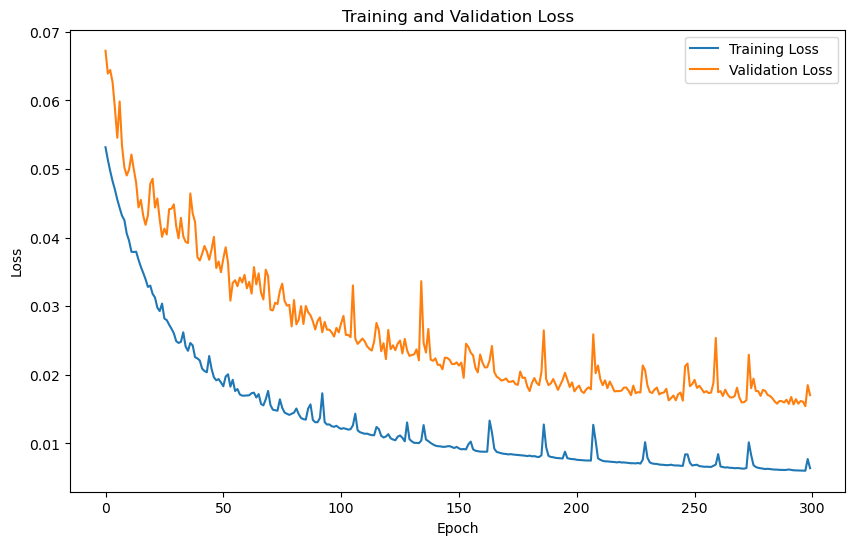

In [17]:
# Plot the loss diagram
plt.figure(figsize=(10, 6))
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training and Validation Loss.png', dpi=600, bbox_inches='tight')
plt.show()

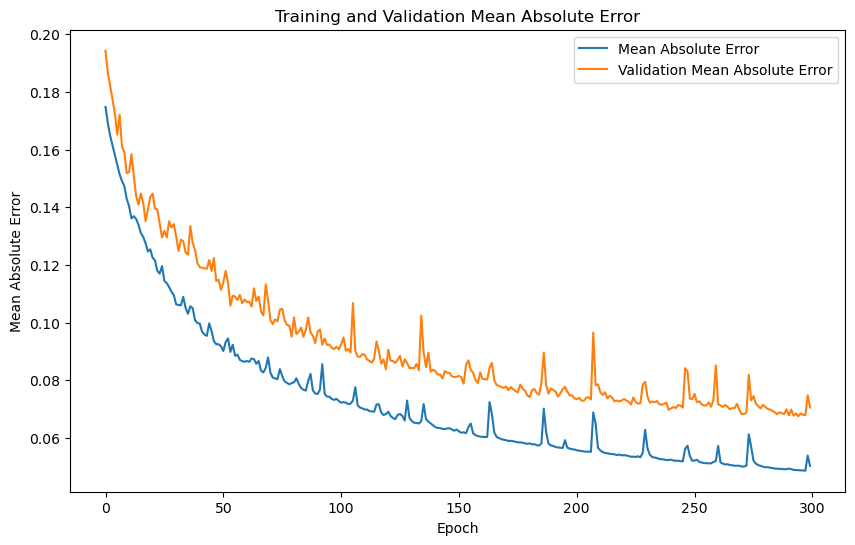

In [18]:
# Plot the accuracy diagram
plt.figure(figsize=(10, 6))
plt.plot(results.history['mae'], label='Mean Absolute Error')
plt.plot(results.history['val_mae'], label='Validation Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('Training and Validation Mean Absolute Error.png', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
solar_max = np.max(solar_values)
solar_min = np.min(solar_values)
print(solar_max)
print(solar_min)

1045434.44
0.0


In [20]:
start_time = time.time()
y_pred1 = model.predict(x_test)

end_time = time.time()
x_test_time_seconds = end_time - start_time
x_test_time_minutes = x_test_time_seconds / 60

print("x_test_Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_test_time_seconds, x_test_time_minutes))

48/48 [==============================] - 1s 17ms/step
x_test_Prediction completed in 1.18 seconds (0.02 minutes)


In [21]:

start_time = time.time()
y_train_pred =  model.predict(x_train)

end_time = time.time()
x_train_time_seconds = end_time - start_time
x_train_time_minutes = x_train_time_seconds / 60

print("x_train_Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_train_time_seconds,x_train_time_minutes))

152/152 [==============================] - 1s 9ms/step
x_train_Prediction completed in 2.07 seconds (0.03 minutes)


In [14]:
y_pred1 = model.predict(x_test)
y_pred = y_pred1 * (solar_max - solar_min) + solar_min
y_test2 = y_test * (solar_max - solar_min) + solar_min


48/48 [==============================] - 1s 14ms/step


In [22]:

start_time = time.time()
y_train_pred =  model.predict(x_data_dsm)

end_time = time.time()
x_data_dsm_time_seconds = end_time - start_time
x_data_dsm_time_minutes = x_data_dsm_time_seconds / 60

print("x_data_dsm_Prediction completed in {:.2f} seconds ({:.2f} minutes)".format(x_data_dsm_time_seconds,x_data_dsm_time_minutes))

237/237 [==============================] - 2s 8ms/step
x_data_dsm_Prediction completed in 2.86 seconds (0.05 minutes)


In [15]:
# Flatten the arrays
y_test2_flat = y_test2.flatten()
y_pred_flat = y_pred.flatten()

# Calculate R^2
r2 = r2_score(y_test2_flat, y_pred_flat)

In [ ]:
# Calculate R^2 for training data
y_train_pred = model.predict(x_train)
y_train_pred2 = y_train_pred * (solar_max - solar_min) + solar_min
y_train2 = y_train * (solar_max - solar_min) + solar_min
# # Flatten the arrays
y_train_pred2_flat = y_train_pred2.flatten()
y_train2_flat = y_train2.flatten()

# Calculate R^2 for training data
r2_train = r2_score(y_train2_flat, y_train_pred2_flat)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Flatten the arrays
y_train_denormalized_flat =y_train_pred2.flatten()
y_train_pred_flat = y_train2.flatten()

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train_denormalized_flat, y_train_pred_flat))
train_mae = mean_absolute_error(y_train_denormalized_flat, y_train_pred_flat)
train_r2 = r2_score(y_train_denormalized_flat, y_train_pred_flat)

# Flatten the arrays for test data as well
y_test_denormalized_flat = y_test2.flatten()
y_test_pred_flat = y_pred.flatten()

# Calculate metrics for test data
test_rmse = np.sqrt(mean_squared_error(y_test_denormalized_flat, y_test_pred_flat))
test_mae = mean_absolute_error(y_test_denormalized_flat, y_test_pred_flat)
test_r2 = r2_score(y_test_denormalized_flat, y_test_pred_flat)

# Print or use the metrics as needed
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R2: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2: {test_r2:.4f}")


Train RMSE: 108357.2578
Train MAE: 68781.1406
Train R2: 0.8762
Test RMSE: 138524.6250
Test MAE: 79422.3125
Test R2: 0.8143


In [82]:
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.03611369431018829
Test accuracy: 0.09131297469139099
